# Display results
This code enables easy selection of experimental results and plotting their values

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def satistifies_conditions(experiment, conditions):
    """ Check if experiment hyperparameters satisfy desired conditions
    """
    hp = experiment['hyperparameters']
    
    # Check if each condition satistified
    # If not, then return false
    for key, value in conditions.items():
        if key not in hp or hp[key] not in value:
            return False
    
    # All conditions are satisfied
    return True

In [3]:
def load_experiments_satisfying_conditions(conditions, anti_conditions=dict()):
    """ Load all experiments that satisfy the given conditions,
    except those that also satisfy the anticonditions
    Return them as a list.
    """
    # Get all experiment filenames
    experiment_filenames = [f for f in os.listdir(os.getcwd()) if f[-5:] == '.json']
    
    # Initialize list of experiments that satisfy the conditions
    experiments_satisfactory = []
    
    # Load each experiment file
    for experiment_filename in experiment_filenames:
        with open(experiment_filename) as experiment_file:
            experiment = json.load(experiment_file)
            
            # Check if experiment satistifies conditions
            # If so, append to list of experiments satisfying the conditions
            if satistifies_conditions(experiment, conditions):
                if anti_conditions == dict() or not satistifies_conditions(experiment, anti_conditions):
                    experiments_satisfactory.append(experiment)
                
    return experiments_satisfactory

In [4]:
def get_per_epoch_performance(experiments, dataset, measure):
    """ For each experiment return it performance on the given dataset for the given measure
    """
    
    # Check that the dataset and measure is valid
    assert measure in {'average_accuracy', 'average_loss'}
    assert dataset in {'train', 'test'}
    
    # Infer the number of epochs and experiments
    # and create corresponding performance matrix
    num_epochs = experiments[0]['hyperparameters']['epochs']
    num_experiments = len(experiments)
    performance = np.zeros((num_experiments, num_epochs))
    
    # Extract performances
    for i, experiment in enumerate(experiments):
        performance[i, :] = experiment['results'][dataset][measure]
        
    return performance
        

# Example usage

In [5]:
# Specify conditions for experiments
conditions = {
    'architecture': {'convffnn'},
    'batch_size': {100},
    'clipping_threshold': {0.0},
    'dataset_name': {'mnist'},
    'epochs': {3},
    'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
    'lr': {0.1},
    'momentum': {0.0},
    'mu': {0.0},
    'seed': {1,2,3,4,5,6,7,8,9,10},
    'sgdtype': {'explicit'}}

In [6]:
# Load experiments and their performance
experiments = load_experiments_satisfying_conditions(conditions)
measure = 'average_accuracy'
performance = get_per_epoch_performance(experiments, 'train', measure)

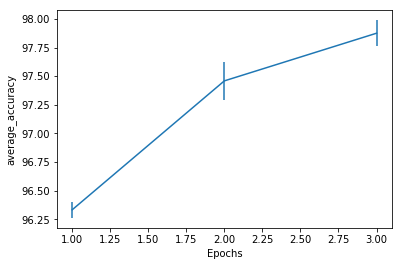

In [7]:
# Create data for plotting
epochs = performance.shape[1]
x = np.arange(1,1+epochs)
y = np.mean(performance,0)
yerr = np.std(performance,0)

# Plot!
plt.figure()
plt.errorbar(x, y, yerr=yerr)
plt.xlabel('Epochs')
plt.ylabel(measure)
plt.show()

# Mnist experiments

In [8]:
def get_minst_conditions(sgdtype, lr):
    condition = {
    'architecture': {'convffnn'},
    'batch_size': {100},
    'clipping_threshold': {0.0},
    'dataset_name': {'mnist'},
    'epochs': {1},
    'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
    'lr': {lr},
    'momentum': {0.0},
    'mu': {0.0},
    'seed': set(range(1,21)),
    'sgdtype': {sgdtype}
    }
    
    if sgdtype == 'exact ISGD':
        condition = {
        'architecture': {'convffnn'},
        'batch_size': {100},
        'clipping_threshold': {0.0},
        'dataset_name': {'mnist'},
        'epochs': {1},
        'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
        'inner_ISGD_iterations': [10],  # '0.1'
        'lr': {lr},
        'momentum': {0.0},
        'mu': {0.0},
        'seed': set(range(1,21)),
        'sgdtype': {'explicit'}
        }
    
    return condition

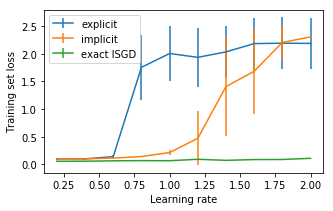

In [9]:
# Select what parameters to fix
measure = 'average_loss' # 'average_accuracy' # 
dataset = 'train'
scatter = False

# Gather the data
learning_rates = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6,1.8, 2.0]#  [i/10.0 for i in range(1,21)] looks a bit messy
sgdtypes = ['explicit', 'implicit', 'exact ISGD']
results = {sgdtype: {} for sgdtype in sgdtypes}
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_minst_conditions(sgdtype, lr)
        anticondition = dict() if sgdtype == 'exact ISGD' else {'inner_ISGD_iterations': [0,100]}
        experiments = load_experiments_satisfying_conditions(conditions, anticondition)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        if scatter:
            results[sgdtype][lr] = performance
        else:
            results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Plot
with PdfPages('../plots/mnist_classification_' + measure + '.pdf') as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)
    for sgdtype in sgdtypes:
        if scatter:
            for lr in learning_rates:
                y = results[sgdtype][lr]
                x = lr * np.ones(results[sgdtype][lr].shape)
                plt.scatter(x, y,color='C1' if sgdtype=='implicit' else 'C0')
        else:
            x = learning_rates
            y = [results[sgdtype][lr][0] for lr in learning_rates]
            yerr = [results[sgdtype][lr][1] for lr in learning_rates]
            plt.errorbar(x, y, yerr=yerr, label=sgdtype)
    plt.xlabel('Learning rate')
    plt.ylabel('Training set loss' if measure == 'average_loss' else 'Training set accuracy')
    plt.legend()

    # Save figure
    pdf.savefig(bbox_inches="tight")
    plt.show()

# Difference between exact formulations

In [10]:
def get_exact_conditions(sgdtype, lr):
    
    if sgdtype == 'exact ISGD 100':
        condition = {
        'architecture': {'convffnn'},
        'batch_size': {100},
        'clipping_threshold': {0.0},
        'dataset_name': {'mnist'},
        'epochs': {1},
        'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
        'inner_ISGD_iterations': [100],  # '0.1'
        'lr': {lr},
        'momentum': {0.0},
        'mu': {0.0},
        'seed': set(range(1,21)),
        'sgdtype': {'explicit'}
        }
    
    if sgdtype == 'exact ISGD 10':
        condition = {
        'architecture': {'convffnn'},
        'batch_size': {100},
        'clipping_threshold': {0.0},
        'dataset_name': {'mnist'},
        'epochs': {1},
        'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
        'inner_ISGD_iterations': [10],  # '0.1'
        'lr': {lr},
        'momentum': {0.0},
        'mu': {0.0},
        'seed': set(range(1,21)),
        'sgdtype': {'explicit'}
        }
    
    return condition

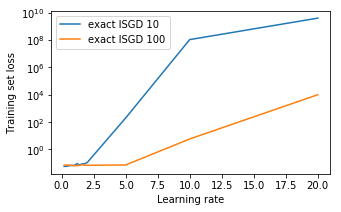

In [11]:
# Select what parameters to fix
measure = 'average_loss' # 'average_accuracy' # 
dataset = 'train'
scatter = False

# Gather the data
learning_rates = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6,1.8, 2.0,5.0, 10.0, 20.0]# 
sgdtypes = ['exact ISGD 10', 'exact ISGD 100']
results = {sgdtype: {} for sgdtype in sgdtypes}
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_exact_conditions(sgdtype, lr)
        experiments = load_experiments_satisfying_conditions(conditions, anticondition)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        if scatter:
            results[sgdtype][lr] = performance
        else:
            results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Plot
with PdfPages('../plots/exact_ISGD_classification_' + measure + '.pdf') as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)
    for sgdtype in sgdtypes:
        if scatter:
            for lr in learning_rates:
                y = results[sgdtype][lr]
                x = lr * np.ones(results[sgdtype][lr].shape)
                plt.scatter(x, y,color='C1' if sgdtype=='implicit' else 'C0')
        else:
            x = learning_rates
            y = [results[sgdtype][lr][0] for lr in learning_rates]
            yerr = [results[sgdtype][lr][1] for lr in learning_rates]
            plt.semilogy(x, y, label=sgdtype)
    plt.xlabel('Learning rate')
    plt.ylabel('Training set loss' if measure == 'average_loss' else 'Training set accuracy')
    plt.legend()

    # Save figure
#     pdf.savefig(bbox_inches="tight")
    plt.show()

# Mnist experiments with intra-epoch losses

In [12]:
def get_minst_intra_epoch_conditions(lr):
    condition = {
    'architecture': ['convffnn'],
    'batch_size': [100],
    'clipping_threshold': [0.0],
    'dataset_name': ['mnist'],
    'epochs': [1],
    'initialization_scale': ['\sqrt{\frac{6}{n+m}}'],
    'intra_epoch': [True],
    'lr': [lr],#, 
    'momentum': [0.0],
    'mu': [0.0],
    'nodes': [50],
    'seed': list(range(1,6)),
    'sgdtype': ['explicit']
    }
    
    return condition

In [13]:
def get_per_intra_epoch_performance(experiments, measure):
    """ For each experiment return it performance on the given dataset for the given measure
    """
    
    # Check that the dataset and measure is valid
    assert measure in {'average_loss_intra_epoch', 'average_accuracy_intra_epoch'}
    
    # Infer the number of epochs and experiments
    # and create corresponding performance matrix
    num_intra = len(experiments[0]['results'][measure])
    num_experiments = len(experiments)
    performance = np.zeros((num_experiments, num_intra))
    
    # Extract performances
    for i, experiment in enumerate(experiments):
        performance[i, :] = experiment['results'][measure]
        
    return performance
        

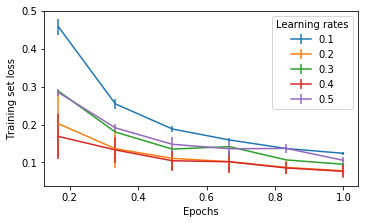

In [14]:
# Select what parameters to fix
measure = 'average_loss_intra_epoch' # 'average_accuracy_intra_epoch' #
dataset = 'train'
scatter = False

# Gather the data
learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5]#, 1.0] # [0.1, 0.2, 0.3, 0.4, 0.5]
sgdtypes = 'explicit'
results = {}
for lr in learning_rates:
    conditions = get_minst_intra_epoch_conditions(lr)
    experiments = load_experiments_satisfying_conditions(conditions)
    results[lr] = get_per_intra_epoch_performance(experiments, measure)
    
# Plot
with PdfPages('../plots/intra_epoch_' + measure + '.pdf') as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)
    num_intra = len(experiments[0]['results'][measure])
    x = list(np.arange(1, 1 + num_intra) / num_intra)
    for lr in learning_rates:
        y = np.mean(results[lr],axis=0)
        yerr = np.std(results[lr],axis=0)
        plt.errorbar(x, y, yerr=yerr, label=lr)
    plt.xlabel('Epochs')
    plt.ylabel('Training set loss' if measure == 'average_loss_intra_epoch' else 'Training set accuracy')
    plt.legend(title='Learning rates')
    plt.tight_layout(pad=0.3)

    # Save figure
    pdf.savefig(bbox_inches="tight")
    plt.show()

# Mnist experiments with clipping

In [15]:
def get_minst_clipping_conditions(sgdtype, lr):
    condition = {
    'architecture': {'convffnn'},
    'batch_size': {100},
    'clipping_threshold': {1.0},
    'dataset_name': {'mnist'},
    'epochs': {1},
    'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
    'lr': {lr},
    'momentum': {0.0},
    'mu': {0.0},
    'seed': set(range(1,21)),# - set([1]),
    'sgdtype': {sgdtype}
    }
    
    return condition

In [16]:
def get_minst_clipping_anti_conditions(sgdtype, lr):
    condition = {
    'inner_ISGD_iterations': {0, 10},  # '0.1'
    'intra_epoch': {True, False}
    }
    
    return condition

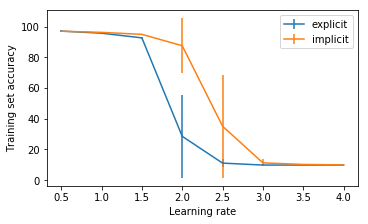

In [17]:
# Select what parameters to fix
measure = 'average_accuracy' # 'average_loss' # 
dataset = 'train'

# Gather the data
learning_rates = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4]
#[0.25, 0.5, 0.75, 1.0,1.25,1.5,1.75,2.0]#[i/10.0 for i in range(1,21)]
sgdtypes = ['explicit', 'implicit']
results = {sgdtype: {} for sgdtype in sgdtypes}
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_minst_clipping_conditions(sgdtype, lr)
        anti_conditions = get_minst_clipping_anti_conditions(sgdtype, lr)
        experiments = load_experiments_satisfying_conditions(conditions, anti_conditions)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Plot
with PdfPages('../plots/minst_classification_clipping_' + measure + '.pdf') as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)
    for sgdtype in sgdtypes:
        x = learning_rates
        y = [results[sgdtype][lr][0] for lr in learning_rates]
        yerr = [results[sgdtype][lr][1] for lr in learning_rates]
        plt.errorbar(x, y, yerr=yerr, label=sgdtype)
    plt.xlabel('Learning rate')
    plt.ylabel('Training set loss' if measure == 'average_loss_intra_epoch' else 'Training set accuracy')
    plt.legend()
    plt.tight_layout(pad=0.3)

    # Save figure
    pdf.savefig(bbox_inches="tight")
    plt.show()

# Autoencoder experiments

In [18]:
def get_minst_autoencoder_conditions(sgdtype, lr):
    condition = {
    "architecture": {"autoencoder"},
    "batch_size": {100},
    "clipping_threshold": {0.0},
    "dataset_name": {"mnist_autoencoder"},
    "epochs": {1},
    "initialization_scale": {"\\sqrt{\frac{6}{n+m}}"},
    "lr": {lr},
    "momentum": {0.0},
    "mu": {0.0},
    "seed": set(range(1,21)),
    "sgdtype": {sgdtype},
    "data_type": {"autoencoder"}
    }
    
    return condition

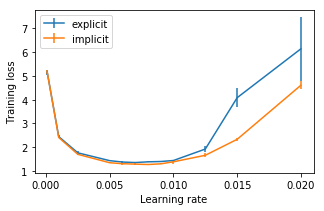

In [19]:
# Select what parameters to fix
dataset = 'train'

# Gather the data
measure = 'average_loss'
learning_rates = [0.0001,0.001, 0.0025, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.0125, 0.015, 0.02]
sgdtypes = ['explicit', 'implicit']
results = {sgdtype: {} for sgdtype in sgdtypes}
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_minst_autoencoder_conditions(sgdtype, lr)
        experiments = load_experiments_satisfying_conditions(conditions)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Plot
with PdfPages('../plots/minst_autoencoder_' + measure + '.pdf') as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)#
    for sgdtype in sgdtypes:
        x = learning_rates
        y = [results[sgdtype][lr][0] for lr in learning_rates]
        yerr = [results[sgdtype][lr][1] for lr in learning_rates]
        plt.errorbar(x, y, yerr=yerr, label=sgdtype)
    plt.xlabel('Learning rate')
    plt.ylabel('Training loss')
    plt.legend(loc="upper left")
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(5)) # Specifies the maximum number of ticks

    # Save figure
    pdf.savefig(bbox_inches="tight")
    plt.show()

# Autoencoder with clipping experiments

In [20]:
def get_minst_autoencoder_clipping_conditions(sgdtype, lr):
    condition = {
    "architecture": {"autoencoder"},
    "batch_size": {100},
    "clipping_threshold": {1.0},
    "dataset_name": {"mnist_autoencoder"},
    "epochs": {1},
    "initialization_scale": {"\\sqrt{\frac{6}{n+m}}"},
    "lr": {lr},
    "momentum": {0.0},
    "mu": {0.0},
    "seed": set(range(1,21)),
    "sgdtype": {sgdtype}
    }
    
    return condition

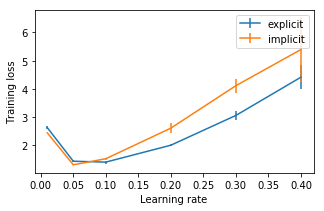

In [21]:
# Select what parameters to fix
dataset = 'train'

# Gather the data
measure = 'average_loss'
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4] # , 0.5
sgdtypes = ['explicit', 'implicit']
results = {sgdtype: {} for sgdtype in sgdtypes}
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_minst_autoencoder_clipping_conditions(sgdtype, lr)
        experiments = load_experiments_satisfying_conditions(conditions)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Plot
with PdfPages('../plots/minst_autoencoder_clipped_' + measure + '.pdf') as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)#
    for sgdtype in sgdtypes:
        x = learning_rates
        y = [results[sgdtype][lr][0] for lr in learning_rates]
        yerr = [results[sgdtype][lr][1] for lr in learning_rates]
        plt.errorbar(x, y, yerr=yerr, label=sgdtype)
    plt.xlabel('Learning rate')
    plt.ylabel('Training loss')
    plt.legend()

    # Save figure
    pdf.savefig(bbox_inches="tight")
    plt.show()

# RNN music

In [29]:
def get_music_conditions(sgdtype, lr, dataset_name, clip):
    
    condition = {
        'architecture': ['music'],
        'batch_size': [100],
        'clipping_threshold': [clip],
        'dataset_name': [dataset_name],
        'epochs': [5],
        'initialization_scale': ['\sqrt{\frac{6}{n+m}}'],  # '0.1'
        'inner_ISGD_iterations': [0],
        'intra_epoch': [False],
        'lr': [lr],
        'momentum': [0.0],
        'mu': [0.0],
        'nodes': [300],
        'seed': list(range(1,6)),
        'sgdtype': [sgdtype]}
    
    return condition
 

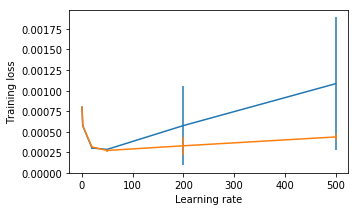

In [97]:
# Select what parameters to fix
dataset = 'train'
epoch_num = 4
clip = 0.0 # 8.0
dataset_name = 'Nottingham' #'JSB Chorales'#'Piano-midi.de'#'MuseData'# 

# Gather the data
measure = 'average_loss'
learning_rates = [0.5, 2.0, 5.0, 20.0, 50.0, 200.0, 500.0]#] #
# learning_rates = [0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]#] #
sgdtypes = ['explicit', 'implicit']
results = {sgdtype: {} for sgdtype in sgdtypes}
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_music_conditions(sgdtype, lr, dataset_name, clip)
        experiments = load_experiments_satisfying_conditions(conditions)
        performance = get_per_epoch_performance(experiments, dataset, measure)[:,epoch_num]
        results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Plot
with PdfPages('../plots/' + '_'.join('JSB Chorales'.split()) +'_' + measure + '.pdf') as pdf:
    plt.figure(figsize=(5,3))#Default = (8.0, 6.0)#
    for sgdtype in sgdtypes:
    #     Plot over learning rates
        x = learning_rates
        y = [results[sgdtype][lr][0] for lr in learning_rates]
        yerr = [results[sgdtype][lr][1] for lr in learning_rates]
        plt.errorbar(x, y, yerr=yerr, label=sgdtype)
        plt.xlabel('Learning rate')

        # Plot over epochs
    #     lr = 200.0
    #     epoch_list = list(range(5))
    #     x = epoch_list
    #     y = [results[sgdtype][lr][e] for e in epoch_list]
    #     plt.xlabel('Epochs')

    #     plt.plot(x, y, label=sgdtype)
    
    plt.ylabel('Training loss')

    # Save figure
    pdf.savefig(bbox_inches="tight")
    plt.show()

# Classification

In [57]:
def get_classification_conditions(sgdtype, lr, dataset_name):
    
    condition = {
    "architecture": ['classification'],
    "batch_size": [100],
    "clipping_threshold": [0.0],
    "dataset_name": [dataset_name],
    "epochs": [10],
    "initialization_scale": ["\\sqrt{\frac{6}{n+m}}"],
    "inner_ISGD_iterations": [0],
    "intra_epoch": [False],
    "lr": [lr],
    "momentum": [0.0],
    "mu": [0.0],
    "nodes": [50],
    "seed": [1,2,3,4,5],
    "sgdtype": [sgdtype]
}
    
    return condition
 

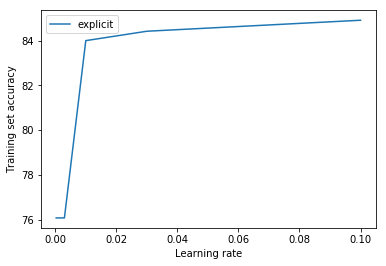

In [89]:
# learning_rates = [0.00001 * (10 ** i) * j for i in range(7) for j in [1,3]]
# learning_rates = [0.00001 * (10 ** i) * j for i in range(5) for j in [1,3]][3:]
learning_rates = [0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]#, 0.2, 0.3, 0.5, 1.0, 3.0, 5.0, 10.0 ,30.0, 50.0]
#dataset_names = [annealing, abalone, adult, connect-4]
dataset = 'train'
epoch_num = 9
measure = 'average_accuracy' #'average_loss' # 

dataset_name = 'adult_classification'

# Gather the data
sgdtypes = ['explicit']#, 'implicit'
results = {sgdtype: {} for sgdtype in sgdtypes}
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_classification_conditions(sgdtype, lr, dataset_name)
        experiments = load_experiments_satisfying_conditions(conditions)
        performance = get_per_epoch_performance(experiments, dataset, measure)[0]
        results[sgdtype][lr] = performance#(np.mean(performance), np.std(performance))

for sgdtype in sgdtypes:
#     Plot over learning rates
    x = learning_rates
    y = [results[sgdtype][lr][epoch_num] for lr in learning_rates]
    plt.xlabel('Learning rate')
    
    # Plot over epochs
#     lr = 200.0
#     epoch_list = list(range(5))
#     x = epoch_list
#     y = [results[sgdtype][lr][e] for e in epoch_list]
#     plt.xlabel('Epochs')
    
    plt.plot(x, y, label=sgdtype)
plt.ylabel('Training set loss' if measure == 'average_loss' else 'Training set accuracy')
plt.legend()
plt.show()

In [85]:
conditions

{'architecture': ['classification'],
 'batch_size': [100],
 'clipping_threshold': [0.0],
 'dataset_name': ['connect-4_classification'],
 'epochs': [10],
 'initialization_scale': ['\\sqrt{\x0crac{6}{n+m}}'],
 'inner_ISGD_iterations': [0],
 'intra_epoch': [False],
 'lr': [3.0],
 'momentum': [0.0],
 'mu': [0.0],
 'nodes': [50],
 'seed': [1, 2, 3, 4, 5],
 'sgdtype': ['explicit']}